## TITLE


imports

In [91]:
import os
import pandas as pd
import numpy as np

#vader
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

#sentiment analysis. svm and lr
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


LOAD FILES


In [92]:
BASE_PATH = "data/raw"

files = [
    "1429_1.csv",
    "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",
    "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
]

dfs = {}

for file in files:
    path = os.path.join(BASE_PATH, file)
    print(f"Loading {file}...")
    temp_df = pd.read_csv(path, encoding="utf-8", low_memory=False)

    # Add column to know source file (useful to remove duplicates)
    temp_df["source_file"] = file

    dfs[file] = temp_df

print("Loading complete")

Loading 1429_1.csv...
Loading Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv...
Loading Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv...
Loading complete


PREPROCESSING

quick EDA

In [93]:
for name, df in dfs.items():
    print("\n" + "="*80)
    print(f"DATASET: {name}")
    print("="*80)
    
    print("\nShape:", df.shape)
    print("\nColumns:")
    print(df.columns.tolist())
    
    print("\nTypes:")
    print(df.dtypes)
    
    print("\nNaN per column:")
    print(df.isna().sum().sort_values(ascending=False).head(20))
    
    print("\nPreview:")
    display(df.head())


DATASET: 1429_1.csv

Shape: (34660, 22)

Columns:
['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'source_file']

Types:
id                       object
name                     object
asins                    object
brand                    object
categories               object
keys                     object
manufacturer             object
reviews.date             object
reviews.dateAdded        object
reviews.dateSeen         object
reviews.didPurchase      object
reviews.doRecommend      object
reviews.id              float64
reviews.numHelpful      float64
reviews.rating          float64
reviews.sourceURLs       object
reviews.text             object
reviews.title            object
rev

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,source_file
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter,1429_1.csv
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman,1429_1.csv
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ,1429_1.csv
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks,1429_1.csv
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42,1429_1.csv



DATASET: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv

Shape: (5000, 25)

Columns:
['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs', 'source_file']

Types:
id                      object
dateAdded               object
dateUpdated             object
name                    object
asins                   object
brand                   object
categories              object
primaryCategories       object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
reviews.date            object
reviews.dateAdded       object
reviews.dateSeen        object
reviews.doRecommend       bool
review

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,source_file
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...



DATASET: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv

Shape: (28332, 25)

Columns:
['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs', 'source_file']

Types:
id                      object
dateAdded               object
dateUpdated             object
name                    object
asins                   object
brand                   object
categories              object
primaryCategories       object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
reviews.date            object
reviews.dateSeen        object
reviews.didPurchase     object
reviews.doRecommend     obje

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,source_file
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...


Merging tables

In [94]:
# see common columns
common_columns = set(next(iter(dfs.values())).columns)

for df in dfs.values():
    common_columns = common_columns.intersection(df.columns)

common_columns = sorted(list(common_columns))

print("Number of common columns:", len(common_columns))
print(common_columns)



Number of common columns: 18
['asins', 'brand', 'categories', 'id', 'keys', 'manufacturer', 'name', 'reviews.date', 'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'source_file']


In [95]:
# reduce dataset to common columns

dfs_common = {}

for name, df in dfs.items():
    dfs_common[name] = df[common_columns].copy()


In [96]:
# clean merge

df_merged = pd.concat(dfs_common.values(), ignore_index=True)

print("Shape after merge:", df_merged.shape)


Shape after merge: (67992, 18)


Removing duplicates

We remove duplicates before dropping unnecessary columns because we're interested in duplicates derived from merging different tables, not unintended duplicated info (e.g. generic review texts like "great value" for the same product). Some of the unnecesarry columns for the project are useful for removing duplicates. Also, for the same reason, not normalizing and using a max subset


In [97]:
# exact rows duplicates

dup_mask_all = df_merged.duplicated(
    subset=common_columns,
    keep=False
)

duplicates_all = df_merged[dup_mask_all]

print("Total fully identical duplicates:", duplicates_all.shape[0])


Total fully identical duplicates: 190


In [98]:
# strong duplicates (same user, key, product, review, etc.)

duplicate_subset = [
    "keys",
    "reviews.username",
    "name",
    "brand",
    "reviews.title",
    "reviews.text",
    "reviews.rating"
]

dup_mask_strong = df_merged.duplicated(
    subset=duplicate_subset,
    keep=False
)

duplicates_strong = df_merged[dup_mask_strong]

print("Total logical duplicates:", duplicates_strong.shape[0])


Total logical duplicates: 2826


In [99]:
#checking source of duplicates
duplicates_strong.groupby("source_file").size()


source_file
1429_1.csv                                                          107
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv          1390
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv    1329
dtype: int64

In [100]:
# remove duplicates
df_merged = df_merged.drop_duplicates(
    subset=duplicate_subset
).reset_index(drop=True)

print("Shape after removing duplicates:", df_merged.shape)



Shape after removing duplicates: (66568, 18)


Working df

In [101]:
# keeping only relevant columns

columns_to_keep = [
    "asins",
    "name",
    "brand",
    "manufacturer",
    'categories',
    "reviews.title",
    "reviews.text",
    "reviews.rating",
    "reviews.doRecommend",
    'reviews.numHelpful',
    "primaryCategories"
]

df = df_merged[columns_to_keep].copy()


print("Shape after dropping unused columns:", df.shape)


KeyError: "['primaryCategories'] not in index"

In [ ]:
# remove nan and empty
df["reviews.title"] = df["reviews.title"].fillna("")
df["reviews.text"] = df["reviews.text"].fillna("")

df = df[
    ~(
        (df["reviews.title"].str.strip() == "") &
        (df["reviews.text"].str.strip() == "")
    )
]

print("Shape after removing rows without title AND text:", df.shape)


Shape after removing rows without title AND text: (67992, 10)


Adding full review column

In [ ]:
df["full_review"] = (
    df["reviews.title"].fillna("") + " " +
    df["reviews.text"].fillna("")
).str.strip()

INSTRUCTIONS SUMMARY
Sentiment analysis
first task: unsupervised, sentiment model. Pos 0.92 neg .12 neg .05
reviews
rating(1-5)
results: only cateogrical. Pos. NEt. Neg

1000 products positive
second task: sort by rating.

Top 3 products. Bottom 3.
favor onger?


Clustering:
unsupervised
(optional supervised, checking against primarycategories)

make 1 csv file that contains info from sentiment and cluster. that feeds model 3: summary of reviews. 

add product id

SENTIMENT ANALYSIS
Goal. Classify product reviews in Positive, negative, neutral.

TODO. Missing removal of discrepancies good review - bad rating. (con vader?)(a posteriori del análisis?)

Preprocessing for Sentiment analysis

In [ ]:
# Creating df for sentiment analysis
df["full_review"] = (
    df["reviews.title"].fillna("") + " " +
    df["reviews.text"].fillna("")
).str.strip()

In [ ]:
df_sa = df.copy()
df_sa = df[df["full_review"] != ""]

In [ ]:
# mapping category to rating numbers
def map_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

df_sa["aux_sentiment"] = df_sa["reviews.rating"].apply(map_sentiment)


In [ ]:
# check category distribution
print(df_sa["aux_sentiment"].value_counts())
print(df_sa["aux_sentiment"].value_counts(normalize=True))

sentiment
positive    62580
neutral      2902
negative     2510
Name: count, dtype: int64
sentiment
positive    0.920402
neutral     0.042681
negative    0.036916
Name: proportion, dtype: float64


Train / test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_sa["full_review"],
    df_sa["aux_sentiment"],
    test_size=0.2,
    stratify=df_sa["aux_sentiment"],
    random_state=42
)

SVM CLASSIFIER

In [ ]:
# pipeline

svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2), 
        stop_words="english"
    )),
    ("clf", LinearSVC(
        class_weight="balanced", # to compensate for unbalanced dataset
        random_state=42
    ))
])

Training

In [ ]:
svm_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


Evaluation

In [ ]:

y_pred_svm = svm_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.77       502
     neutral       0.57      0.52      0.54       580
    positive       0.98      0.98      0.98     12517

    accuracy                           0.95     13599
   macro avg       0.77      0.75      0.76     13599
weighted avg       0.95      0.95      0.95     13599



In [ ]:
# dummy classifier as reference to check if model predicts well or accuracy is based on having an unbalanced dataset

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_dummy = dummy.predict(X_test)

print("SVM - Classification Report")
print(classification_report(y_test, y_dummy))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       502
     neutral       0.00      0.00      0.00       580
    positive       0.92      1.00      0.96     12517

    accuracy                           0.92     13599
   macro avg       0.31      0.33      0.32     13599
weighted avg       0.85      0.92      0.88     13599



c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Interpretation

General interpretation: Model is learning also for minority categories (negative and neutral) as seen in comparison with dummy classifier.
Macro F1 0.32 → 0.76 is significant. Class_wright = balanced is working.

Identifying negative:
Precision: 0.77
Recall: 0.76
F1: 0.77
Solid enough for a class that is only 3.7 % of the dataset.

Identifying neutral:
Precision: 0.57
Recall: 0.52
F1: 0.54
As expected, this is the most difficult category to identify correctly as it is often classified as positive and negative.
227 neutrals classified as positive. Likely due to mild positive language.

Confusion matrix

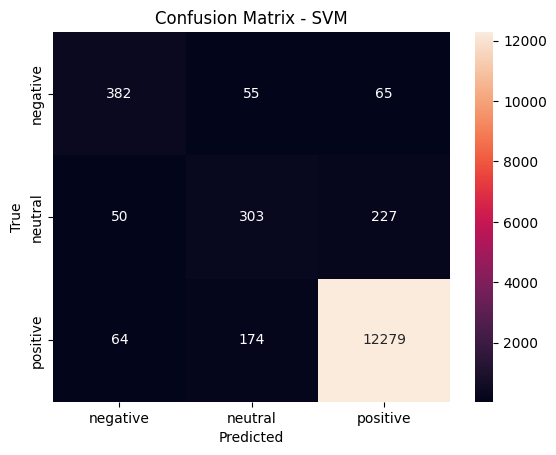

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=["negative","neutral","positive"])

plt.figure()
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["negative","neutral","positive"],
            yticklabels=["negative","neutral","positive"])
plt.title("Confusion Matrix - SVM")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


Check confusion matrix. negative for positive

Cross-validation

In [ ]:
# define cross-validation parameters (stratidiedKfold) 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# execute cross validation
svm_cv_scores = cross_val_score(
    svm_pipeline,
    df_sa["full_review"],
    df_sa["aux_sentiment"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

print("F1-macro scores per fold:", svm_cv_scores)
print("Mean F1-macro:", svm_cv_scores.mean())
print("Std deviation:", svm_cv_scores.std())

F1-macro scores per fold: [0.75659749 0.75838711 0.76610124 0.7605951  0.77082673]
Mean F1-macro: 0.7625015339638544
Std deviation: 0.005247618035412601


Conclusion
Std deviation: 0.005247618035412601
Very low standard deviation, model is stable, doesn't depend much on the split.
Expected performance around 76%.

LOGISTIC REGRESSION CLASSIFIER

In [ ]:
# pipeline

lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced", # to compensate for unbalanced dataset
        solver="lbfgs"
    ))
])

training

In [ ]:
lr_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


Evaluation

In [ ]:
y_pred_lr = lr_pipeline.predict(X_test)

In [ ]:

print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))

Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.57      0.82      0.67       502
     neutral       0.31      0.65      0.42       580
    positive       0.99      0.92      0.95     12517

    accuracy                           0.90     13599
   macro avg       0.62      0.80      0.68     13599
weighted avg       0.94      0.90      0.92     13599



Comparison SVM vs LR

In [ ]:
# macro f1 score
# svm f1 score
macro_f1_svm = f1_score(y_test, y_pred_svm, average="macro")
print("SVM - Macro F1:", macro_f1_svm)
# lr f1 score
macro_f1_lr = f1_score(y_test, y_pred_lr, average="macro")
print("Logistic Regression - Macro F1:", macro_f1_lr)


SVM - Macro F1: 0.7631231510487083
Logistic Regression - Macro F1: 0.6826173041971287


In [ ]:
# pasting classification reports again for analysis convenience
print("SVM - Classification Report")
print(classification_report(y_test, y_dummy))
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))

SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       502
     neutral       0.00      0.00      0.00       580
    positive       0.92      1.00      0.96     12517

    accuracy                           0.92     13599
   macro avg       0.31      0.33      0.32     13599
weighted avg       0.85      0.92      0.88     13599

Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.57      0.82      0.67       502
     neutral       0.31      0.65      0.42       580
    positive       0.99      0.92      0.95     12517

    accuracy                           0.90     13599
   macro avg       0.62      0.80      0.68     13599
weighted avg       0.94      0.90      0.92     13599



c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Interpretation

The Linear SVM clearly outperforms Logistic Regression in multiclass sentiment classification, achieving a substantially higher macro F1-score and a better balance between precision and recall across the minority classes

Conclusion

Therefore, We'll use the Linear SVM as the primary classification model due to its superior performance, while Logistic Regression is employed to estimate sentiment intensity through its probabilistic outputs.

The decision function (distance to the plane) from the SVM could be use as a sort of grading and sorting mechanism, but it's a worse solution than LR for sorting, and more importantly in our case, when looking for reviews of extreme intensity (positive and negative)

PREPROCESSING FOR REVIEW GENERATION: GRADING INTENSITY AND SORTING

In [ ]:
# first we add the classification obtained with SVM to the dataset
df_sa["svm_sentiment"] = svm_pipeline.predict(df_sa["full_review"])

get the probabilities of each review for positive, negative and neuttral with LR

In [ ]:
# we get the probabilities of each review for positive, negative and neuttral
probabilities = lr_pipeline.predict_proba(df_sa["full_review"])
classes = lr_pipeline.named_steps["clf"].classes_

In [ ]:
print(classes)  # to check

['negative' 'neutral' 'positive']


In [ ]:
# we get position of the column for each class
pos_idx = list(classes).index("positive")
neg_idx = list(classes).index("negative")
neu_idx = list(classes).index("neutral")

# we add each column with a name to our dataframe
df_sa["prob_positive"] = probabilities[:, pos_idx]
df_sa["prob_negative"] = probabilities[:, neg_idx]
df_sa["prob_neutral"]  = probabilities[:, neu_idx]

Create Intensity metric for each review

Because we want to produce a ranking and ultimately display products on the extremes (top positive and top negative), it's more appropiate to use the difference between positive probability and negative probability rather than just the isolated positive or negative probability. 

In [ ]:
# values close to 1 are the most positive. -1 the most negative.
df_sa["sentiment_intensity"] = (
    df_sa["prob_positive"] - df_sa["prob_negative"]
)

In [90]:
# quick check
df_sa.head()

,asins,name,brand,manufacturer,categories,reviews.title,reviews.text,reviews.rating,reviews.doRecommend,reviews.numHelpful,full_review,sentiment,prob_positive,prob_negative,prob_neutral,sentiment_intensity,svm_label
0,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Kindle,This product so far has not disappointed. My c...,5.0,True,0.0,Kindle This product so far has not disappointe...,positive,0.886915,0.073629,0.039456,0.813286,positive
1,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",very fast,great for beginner or experienced person. Boug...,5.0,True,0.0,very fast great for beginner or experienced pe...,positive,0.704707,0.043267,0.252026,0.661441,positive
2,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...,5.0,True,0.0,Beginner tablet for our 9 year old son. Inexpe...,positive,0.429922,0.024554,0.545524,0.405367,positive
3,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Good!!!,I've had my Fire HD 8 two weeks now and I love...,4.0,True,0.0,Good!!! I've had my Fire HD 8 two weeks now an...,positive,0.971628,0.001492,0.026879,0.970136,positive
4,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Fantastic Tablet for kids,I bought this for my grand daughter when she c...,5.0,True,0.0,Fantastic Tablet for kids I bought this for my...,positive,0.943675,0.023042,0.033283,0.920633,positive


### Imports

In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path


In [ ]:
DATA_PATH = Path("data")


### Kaggle CSV preprocessing


In [ ]:
kaggle_df = pd.read_csv("1429_1.csv")

kaggle_df.head()


In [ ]:
kaggle_df = kaggle_df.rename(columns={
    "name": "product",
    "reviews.text": "review_text",
    "reviews.rating": "rating"
})


### Remove n/a values

In [ ]:
kaggle_df = kaggle_df.dropna()


### Upload Amazon 2023 Jason (bigger datasets)

In [ ]:
def load_jsonl(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

amazon_df = pd.read_json(
    "Books.jsonl",
    lines=True,
    nrows=500000
)

amazon_df.head()



### Keep Only usefull columns

In [ ]:
amazon_df.columns


In [ ]:
amazon_df = amazon_df[
    [
        "asin",
        "text",
        "rating"
    ]
]

amazon_df = amazon_df.rename(columns={
    "asin": "product",
    "text": "review_text",
    "rating": "rating"
})



### Remove n/a values

In [ ]:
amazon_df = amazon_df.dropna()


### Unite datasets

In [ ]:
full_df = pd.concat([kaggle_df, amazon_df], ignore_index=True)

full_df.head()


### Create sentiment label

In [ ]:
def sentiment_label(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

full_df["sentiment"] = full_df["rating"].apply(sentiment_label)


In [ ]:
full_df["sentiment"].value_counts()


### Save clean dataset

In [ ]:
full_df.to_csv("clean_reviews.csv", index=False)


## Sentiment Classification Model 

### We now train a classification model to predict sentiment from product reviwes using supervised learning.

### Step 1 TF_IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(full_df["review_text"])
y = full_df["sentiment"]


### Step 2 Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


### Train Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


### Evaluate Model


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


# Clustering
 ## We now apply clustering to discover common themes in product reviews.Unlicke classification, clustering groups reviews based on simlarity.


#### Step 1 TF_IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

cluster_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

X_cluster = cluster_vectorizer.fit_transform(full_df["review_text"])


## We group reviews into clusters based on similarity (K-Means Clustering)

#### Step 2 KMeans

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(X_cluster)

full_df["cluster"] = clusters


#### Cluster Distribution

In [ ]:
full_df["cluster"].value_counts()


### STep 3 Top Words

In [ ]:
import numpy as np

terms = cluster_vectorizer.get_feature_names_out()

for i in range(5):
    center = kmeans.cluster_centers_[i]
    top_words = [terms[ind] for ind in center.argsort()[-10:]]
    print(f"Cluster {i}: ", top_words)
